# Intrinsic periodicity of the SIR system
Continuing our investigation of the Susceptible-Infected-Recovered system, 

$$
\dot{S} = -\frac{\beta*S*I}{N} + \mu N - \mu S\\

\dot{I} = \frac{\beta*S*I}{N} - \gamma I - \mu I\\

\dot{R} = \gamma I - \mu R
$$

With non-trivial endemic equilbrium 

$$
(S^*, \: I^*, \: R^*) = (\frac{1}{R_0}, \:\: \frac{\mu (R_0-1)}{\beta}, \: \: 1-\frac{1}{R_0} - \frac{\mu (R_0-1)}{\beta}) \\

\text{where} \:\: R_0 = \frac{\beta}{\gamma + \mu}
$$

General analysis of a system's stability of and approach to equilibria is beyond the scope of this notebook, and detailed discussions are available elsewhere (e.g., Keeling/Rohani Box 2.4).  In brief, one constructs the Jacobian of the system at the equilibrium points and computes its eigenvalues.  If all eigenvalues have negative real component, then the equilibrium is stable; if the dominant eigenvalues are complex conjugates, then system approaches equilibrium via damped oscillations, with damping constant equal to the real component and frequency equal to the imaginary component. This is the case for the SIR system around the non-trivial ($R_0 \gt 1$) equilibrium, with dominant eigenvalues:

$$
\Lambda = -\frac{\mu R_0}{2} \pm \frac{\sqrt{\mu^2 R_0^2 - \frac{4}{A G}}}{2} \\
\text{where} \:\: A = \frac{1}{\mu (R_0 -1)} \text{ and } G = \frac{1}{\mu + \gamma}

$$

In general, $\mu^2 R_0^2$ is quite small, and the intrinsic periodicity of the system is $T \approx 2 \pi \sqrt{A G}$.

### Contruct the model
The model is contructed as in notebook 05, though we will not record date of infection here.  As again, we are looking at behavior around the endemic equilibrium, the same considerations of large-ish populations and long simulations apply here. 

### Sanity check
The first test, as always, ensures that certain basic constraints are being obeyed by the model.  

### Scientific test
The scientific test will sample a set of $(\mu, \gamma, R_0)$ tuplets and confirm that the periodicity is as expected

### Future work
The addition of an exposed compartment with rate constant $\sigma$ should change this result, by changing the generation time $G$ to $\frac{1}{\mu + \gamma} + \frac{1}{\mu + \sigma}$


In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from laser.core.propertyset import PropertySet

import laser.core.distributions as dists
from laser.core.demographics import AliasedDistribution
from laser.core.demographics import KaplanMeierEstimator
from laser_generic.models import SIR
from laser_generic.models.model import Model
from laser_generic.newutils import ValuesMap
from laser_generic.newutils import grid


from scipy.ndimage import gaussian_filter1d
from scipy.signal import find_peaks

print("done")
import laser.core
import laser_generic

print(f"{np.__version__=}")
print(f"{laser.core.__version__=}")
print(f"{laser_generic.__version__=}")

f"{np.__version__=}"

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


done
np.__version__='2.3.4'
laser.core.__version__='0.6.0'
laser_generic.__version__='0.0.0'


"np.__version__='2.3.4'"

OK, in testing here, we run into a couple of challenges, and my training in spectral
analysis is a bit old at this point.  Mainly, we're interested in relatively low-frequency
signals relative to our vector length - periods that can be order a few years in a sequence of a few decades,
so only a few oscillations.  Not impossible but tough
Second is that there are lots of other signals that will probably settle down over
time, but may not.  Lastly, there seem to be some windowing effects from the length of the
vector itself.
So some approaches to get arounds this:
Try to start relatively close to equilibrium
Use time-domain autocorrelation spectrum 
Instead of looking for the period of maximum power, specifically look for a peak in the vicinity of 
the expected period.


In [2]:
class Importation:
    def __init__(self, model, infdurdist, infdurmin: int =1, period: int = 180, count: int = 3):
        self.model = model
        self.infdurdist = infdurdist
        self.infdurmin = infdurmin
        self.period = period
        self.count = count

        self.model.nodes.add_vector_property("imports", model.params.nticks + 1, dtype=np.uint32, default=0)

        return
    
    def step(self, tick: int) -> None:
        if tick > 0 and tick % self.period == 0:
            i_susceptible = np.nonzero(self.model.people.state == SIR.State.SUSCEPTIBLE.value)[0]
            if len(i_susceptible) > 0:
                count = min(self.count, len(i_susceptible))
                i_infect = np.random.choice(i_susceptible, size=count, replace=False)
                self.model.people.state[i_infect] = SIR.State.INFECTIOUS.value
                samples = dists.sample_floats(self.infdurdist, np.zeros(count, np.float32))
                samples = np.round(samples)
                samples = np.maximum(samples, self.infdurmin).astype(self.model.people.itimer.dtype)
                self.model.people.itimer[i_infect] = samples
                inf_by_node = np.bincount(self.model.people.nodeid[i_infect], minlength=len(self.model.nodes)).astype(self.model.nodes.S.dtype)
                self.model.nodes.S[tick + 1] -= inf_by_node
                self.model.nodes.I[tick + 1] += inf_by_node
                self.model.nodes.imports[tick] = inf_by_node
            # else:
            #     print(f"No susceptibles to infect at tick {tick}")

        return

In [3]:
pop=2e5
scenario = grid(M=1, N=1, node_size_km=10, population_fn=lambda x,y: pop, origin_x=0, origin_y=0)
initial_infected = 1
scenario["S"] = scenario.population - initial_infected
scenario["I"] = initial_infected
scenario["R"] = 0
parameters = PropertySet(
    {"seed": 4, "nticks": 365*100, "verbose": True, "beta": 0.4, "inf_mean": 12, "cbr": 90, "importation_period": 180, "importation_count": 3}
)


birthrate_map = ValuesMap.from_scalar(parameters.cbr, nnodes=len(scenario), nsteps=parameters.nticks)
model = Model(scenario, parameters, birthrates=birthrate_map.values)
infdurdist = dists.exponential(scale=parameters.inf_mean)
rate_const = 365 * ((1 + parameters.cbr / 1000) ** (1/365) - 1) #to get stable population, small correction factor for the annual age-dist/KM estimators.
stable_age_dist = np.array(1000*np.exp(-rate_const*np.arange(89)))
pyramid = AliasedDistribution(stable_age_dist)
survival = KaplanMeierEstimator(stable_age_dist.cumsum())




200000 agents in f1 nodes: 100%|██████████| 36500/36500 [00:45<00:00, 806.69it/s]


<Figure size 640x480 with 0 Axes>

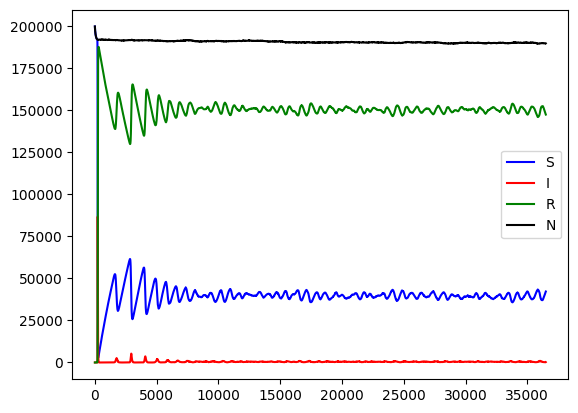

<Figure size 640x480 with 0 Axes>

In [4]:
model.components = [
    SIR.Susceptible(model),
    SIR.Recovered(model),
    SIR.Infectious(model, infdurdist),
    Importation(model, infdurdist),
    SIR.Transmission(model, infdurdist),
    SIR.VitalDynamics(model, birthrates=birthrate_map.values, pyramid=pyramid, survival=survival)
]

model.run()
plt.plot(model.nodes.S, color="blue")
plt.plot(model.nodes.I, color="red")
plt.plot(model.nodes.R, color="green")
plt.plot(model.nodes.S+model.nodes.I+model.nodes.R, color="black")
plt.legend(["S", "I", "R", "N"])
plt.figure()

### Sanity checks
As always, check that we haven't broken anything - S+I+R = N at all times, stocks track flows (need to have deaths by state to do this right)

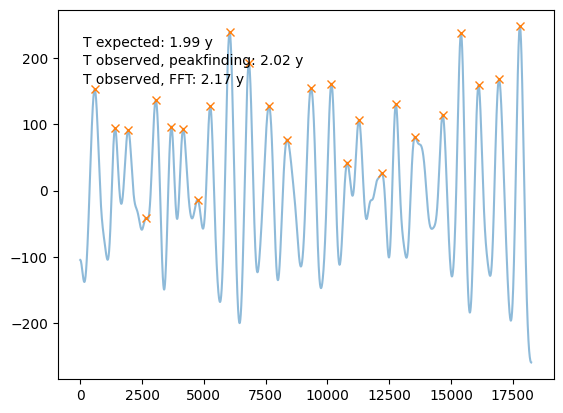

In [5]:
mu = (1 + model.params.cbr / 1000) ** (1 / 365) - 1
R0 = model.params.beta / (1 / model.params.inf_mean + mu)
A = 1 / ((R0 - 1) * mu) / 365
G = 1 / (mu + 1 / model.params.inf_mean) / 365
T_exp = 2 * np.pi * np.sqrt(A * G)


def ID_freq_peakfinder(y0, T_exp, cutoff=18250, plot=False):
    y = y0[cutoff:]
    y = y - np.mean(y)
    y = gaussian_filter1d(y, sigma=100)
    peaks, _ = find_peaks(y, distance=T_exp * 365 / 2)
    if plot:
        plt.figure()
        plt.plot(y, alpha=0.5)
        plt.plot(peaks, y[peaks], "x")
    return np.median(np.diff(peaks)) / 365


T_obs_pf = ID_freq_peakfinder(np.squeeze(model.nodes.I), T_exp, plot=True)


def ID_freq_autocorr(y0, cutoff=18250):
    # Compute the FFT
    Y1 = np.fft.fft(y0[cutoff:] - np.mean(y0[cutoff:]))

    # Compute the circular autocorrelation using the inverse FFT
    circular_autocorr = np.fft.ifft(Y1 * np.conj(Y1)).real
    # Plot only the positive frequency spectrum
    peaks, _ = find_peaks(circular_autocorr, distance=300)
    return peaks[0] / 365


T_obs_fft = ID_freq_autocorr(np.squeeze(model.nodes.I))

plt.text(0.05, 0.9, f"T expected: {T_exp:.2f} y", transform=plt.gca().transAxes)
plt.text(0.05, 0.85, f"T observed, peakfinding: {T_obs_pf:.2f} y", transform=plt.gca().transAxes)
plt.text(0.05, 0.8, f"T observed, FFT: {T_obs_fft:.2f} y", transform=plt.gca().transAxes)
plt.show()

### Larger test suite
OK, so now we are going to replicate the above test for many values of R0 and cbr, as a scientific validity test.

TODO: As written, this takes a long time.  That's because the space of random values being sampled occasionally produces models with long equilibration times and long periodicities.  So as of right now, these run for 100 years to sidestep this.  Should instead restrict the range of values - higher cbrs and R0s - so that the average age at infection is consistently lower and we can get away with running for like 30-50 years instead.  

In [ ]:
nsims = 10
nticks = 36500
cbrs = 70 + 40 * np.random.rand(nsims)
inf_means = 50 + 50 * np.random.rand(nsims)
R0s = 5 + 10 * np.random.rand(nsims)
mu = [((1 + cbr / 1000) ** (1 / 365) - 1) for cbr in cbrs]
A = [1 / ((R0 - 1) * mu) / 365 for R0, mu in zip(R0s, mu)]
G = [1 / (mu + 1 / inf_mean) / 365 for mu, inf_mean in zip(mu, inf_means)]
T_exp = [2 * math.pi * np.sqrt(A * G) for A, G in zip(A, G)]
mycases = np.zeros((nsims, nticks))
params_df = pd.DataFrame(
    {
        "cbr": cbrs,
        "inf_mean": inf_means,
        "R0": R0s,
        "A": A,
        "G": G,
        "T_exp": T_exp,
        "mu": mu,
    }
)

pop=2e5
initial_infected = 1
mycases = np.zeros((nsims, nticks+1))
for i in range(nsims):
    row = params_df.iloc[i]
    scenario = grid(M=1, N=1, node_size_km=10, population_fn=lambda x,y: pop, origin_x=0, origin_y=0)
    parameters = PropertySet(
        {"seed": 42+i, 
         "nticks": 365*100, 
         "verbose": True, 
         "beta": row["R0"] * (row["mu"] + 1 / row["inf_mean"]), 
         "inf_mean": row["inf_mean"], 
         "cbr": row["cbr"], 
         "importation_period": 180, 
         "importation_count": 3}
    )

    scenario["I"] = initial_infected
    scenario["R"] = np.round(pop * (1 / row["R0"] - 0.05)).astype(np.int32)
    scenario["S"] = scenario.population - scenario["I"] - scenario["R"]


    birthrate_map = ValuesMap.from_scalar(parameters.cbr, nnodes=len(scenario), nsteps=parameters.nticks)
    model = Model(scenario, parameters, birthrates=birthrate_map.values)
    infdurdist = dists.exponential(scale=parameters.inf_mean)
    rate_const = 365 * ((1 + parameters.cbr / 1000) ** (1/365) - 1) #to get stable population, small correction factor for the annual age-dist/KM estimators.
    pyramid = AliasedDistribution(stable_age_dist := np.array(1000*np.exp(-rate_const*np.arange(89))))
    survival = KaplanMeierEstimator(stable_age_dist.cumsum())
    
    model.components = [
        SIR.Susceptible(model),
        SIR.Recovered(model),
        SIR.Infectious(model, infdurdist),
        Importation(model, infdurdist),
        SIR.Transmission(model, infdurdist),
        SIR.VitalDynamics(model, birthrates=birthrate_map.values, pyramid=pyramid, survival=survival)
    ]

    model.run()
    mycases[i, :] = np.squeeze(model.nodes.I)

200000 agents in f1 nodes: 100%|██████████| 36500/36500 [00:44<00:00, 819.42it/s]


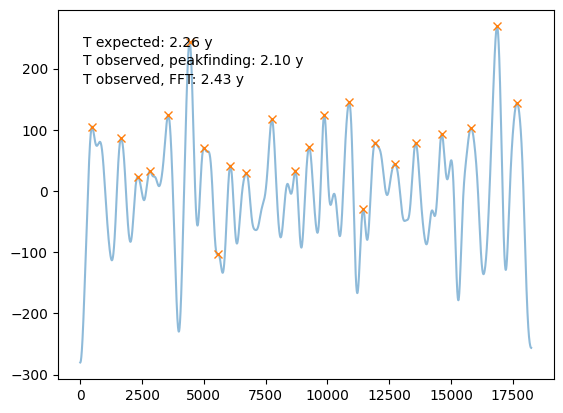

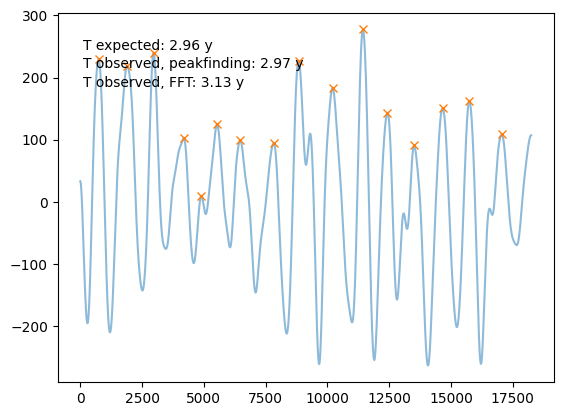

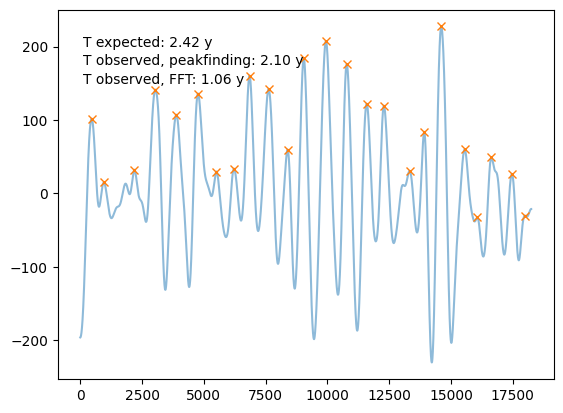

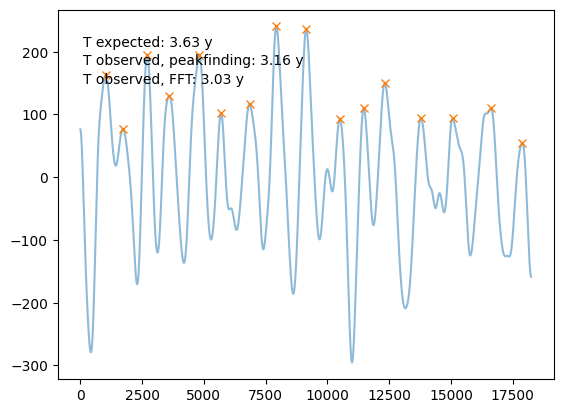

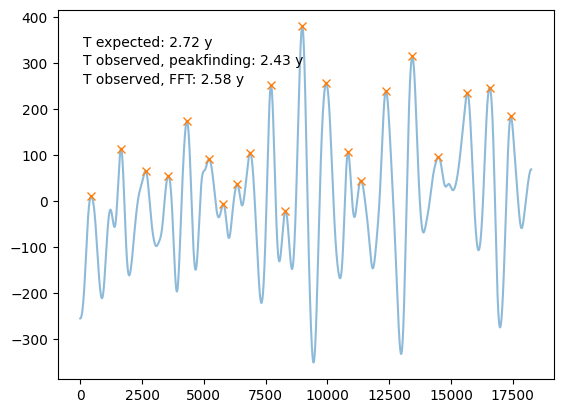

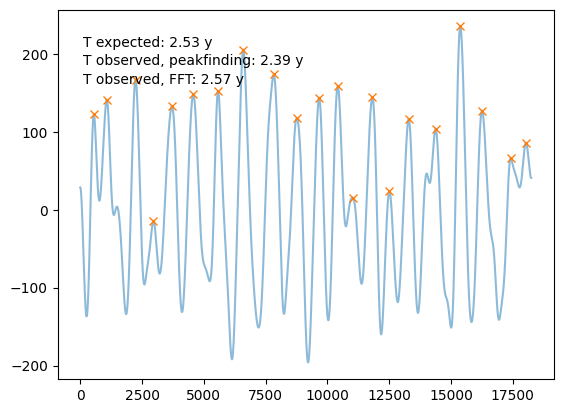

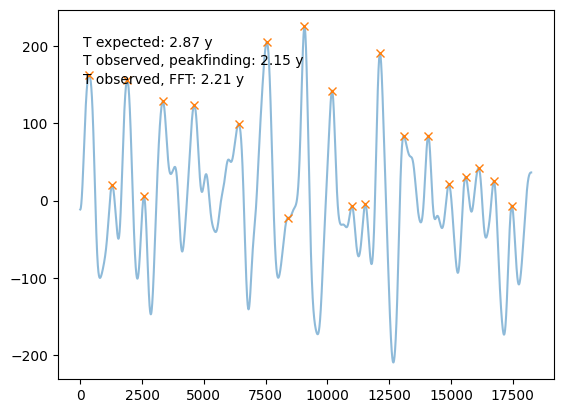

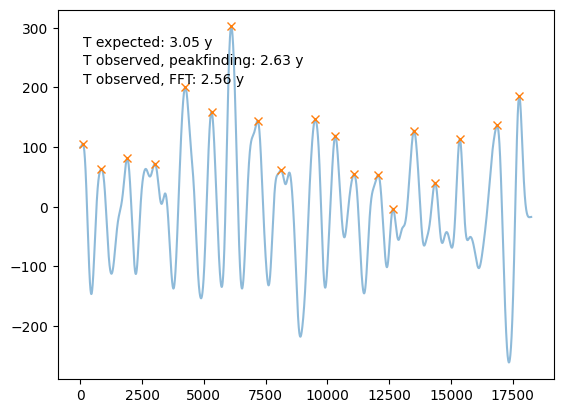

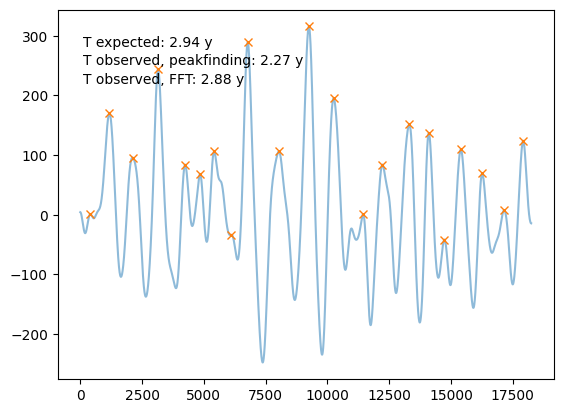

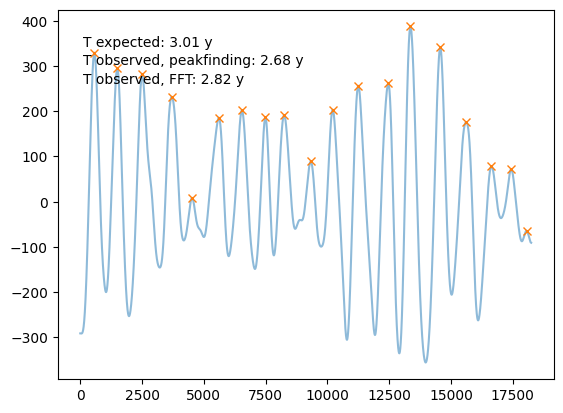

In [15]:
params_df["T_obs_peakfinder"] = np.nan
params_df["T_obs_autocorr"] = np.nan

for i in range(mycases.shape[0]):
    #plt.plot(mycases[i, :])
    params_df.loc[i, "T_obs_peakfinder"] = ID_freq_peakfinder(np.squeeze(mycases[i, :]), params_df.loc[i, "T_exp"], plot=True)
    params_df.loc[i, "T_obs_autocorr"] = ID_freq_autocorr(np.squeeze(mycases[i, :]))
    plt.text(0.05, 0.9, f"T expected: {params_df.loc[i, 'T_exp']:.2f} y", transform=plt.gca().transAxes)
    plt.text(0.05, 0.85, f"T observed, peakfinding: {params_df.loc[i, 'T_obs_peakfinder']:.2f} y", transform=plt.gca().transAxes)
    plt.text(0.05, 0.8, f"T observed, FFT: {params_df.loc[i, 'T_obs_autocorr']:.2f} y", transform=plt.gca().transAxes)
    plt.show()

In [10]:
params_df

,cbr,inf_mean,R0,A,G,T_exp,mu,T_obs_peakfinder,T_obs_autocorr
0,105.815468,55.098123,12.429769,0.869717,0.148696,2.259530,0.000276,2.100000,2.432877
1,81.180730,68.961069,11.727203,1.194190,0.186188,2.962736,0.000214,2.969863,3.126027
2,75.119585,51.653045,14.059858,1.057033,0.140079,2.417748,0.000198,2.101370,1.057534
3,77.043373,66.180346,8.239209,1.860997,0.178908,3.625499,0.000203,3.161644,3.032877
4,105.496316,87.229183,13.390858,0.804567,0.233389,2.722710,0.000275,2.434247,2.580822
5,86.244658,57.611636,12.607196,1.041307,0.155805,2.530816,0.000227,2.389041,2.572603
6,80.411467,69.950977,12.731478,1.102011,0.188847,2.866342,0.000212,2.146575,2.213699
7,80.093426,85.222286,13.665266,1.024663,0.229359,3.045990,0.000211,2.634247,2.558904
8,70.849499,54.101704,10.778693,1.493794,0.146735,2.941656,0.000188,2.267123,2.884932
9,78.023815,50.926662,9.017038,1.660086,0.138078,3.008200,0.000206,2.680822,2.824658


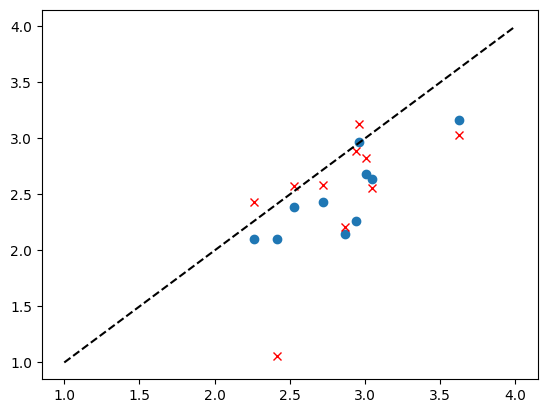

In [16]:
plt.plot(params_df["T_exp"], params_df["T_obs_peakfinder"], "o")
plt.plot(params_df["T_exp"], params_df["T_obs_autocorr"], "rx")
plt.plot([1, 4], [1, 4], "k--")

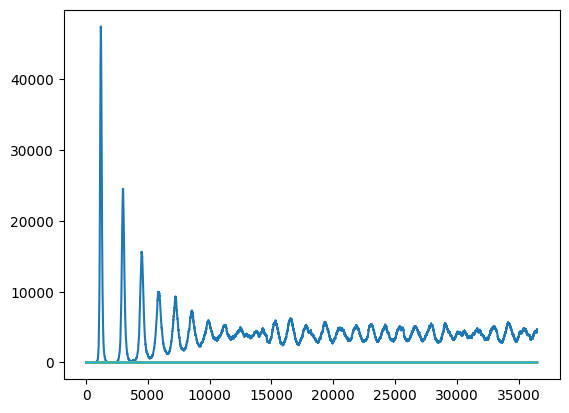